In [ ]:
import os
import cv2
import mediapipe as mp
import numpy as np
import json
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
from sklearn.preprocessing import MinMaxScaler
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import shutil

NORMAL_FOLDER = 'medias/train_video/normal'
FALL_FOLDER = 'medias/train_video/fall'
OUTPUT_NORMAL_FOLDER = 'outputs/skeletons/N01/normal'
OUTPUT_FALL_FOLDER = 'outputs/skeletons/N01/fall'
MODEL_SAVE_PATH = 'outputs/models/cnn_lstm_fall_detection_model_N01_1.h5'
SCALER_SAVE_PATH = 'outputs/models/scaler_N01_1.pkl'
TEST_VIDEO_PATH = 'medias/test/normal/IMG_7694.mp4'
TEST_NORMAL_FOLDER = "medias/test/normal/"
TEST_FALL_FOLDER = "medias/test/fall/"
TIME_STEPS = 60
INFERENCE_FREQUENCY = 10
FPS_STANDARD = 60

mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

I0000 00:00:1748278511.122642  163290 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1748278511.266578  226670 gl_context.cc:369] GL version: 3.0 (OpenGL ES 3.0 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: D3D12 (Intel(R) Iris(R) Xe Graphics)


W0000 00:00:1748278511.320870  226649 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1748278511.360619  226667 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [65]:
def extract_skeleton_points(image):
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    rgb_image = np.ascontiguousarray(rgb_image)
    results = pose.process(rgb_image)
    if results.pose_landmarks:
        return [(lm.x, lm.y, lm.visibility) for lm in results.pose_landmarks.landmark]
    return []

def process_and_save_skeleton_data(video_path, output_file, progress_bar=None):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Failed to open video file: {video_path}")
        return

    skeleton_data = []
    while True:
        success, frame = cap.read()
        if not success or frame is None:
            break

        skeleton_points = extract_skeleton_points(frame)
        if skeleton_points:
            skeleton_data.append(skeleton_points)
        else:
            skeleton_data.append([(0, 0, 0)] * 33)
        if progress_bar:
            progress_bar.update(1)
    cap.release()

    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(skeleton_data, f)

def count_frames_in_video(video_path):
    cap = cv2.VideoCapture(video_path)
    count = 0
    while True:
        success, _ = cap.read()
        if not success:
            break
        count += 1
    cap.release()
    return count

def process_videos_from_folder(folder_path, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    video_files = [video_file for video_file in os.listdir(folder_path) if video_file.lower().endswith(('.mp4', '.avi', '.mov'))]
    total_frames = 0
    for video_file in video_files:
        video_path = os.path.join(folder_path, video_file)
        total_frames += count_frames_in_video(video_path)
    with tqdm(total=total_frames, desc=f"Processing frames in {folder_path}") as pbar:
        for video_file in video_files:
            video_path = os.path.join(folder_path, video_file)
            output_file = os.path.join(output_folder, f'{os.path.splitext(video_file)[0]}.json')
            process_and_save_skeleton_data(video_path, output_file, progress_bar=pbar)

In [66]:
def calculate_acceleration(skeleton_data):
    acceleration = []
    for i in range(1, len(skeleton_data)):
        frame_accel = [
            ((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2) ** 0.5
            for p1, p2 in zip(skeleton_data[i - 1], skeleton_data[i])
        ]
        acceleration.append(frame_accel)
    return acceleration

def normalize_skeleton_data(skeleton_data, scaler, time_steps=60):
    skeleton_data = skeleton_data[-time_steps:] if len(skeleton_data) >= time_steps else skeleton_data
    if len(skeleton_data) < time_steps:
        padding = [[(0, 0, 0)] * 33] * (time_steps - len(skeleton_data))
        skeleton_data = padding + skeleton_data

    accel_features = calculate_acceleration(skeleton_data)
    if len(accel_features) < time_steps:
        accel_features = [[0] * 33] * (time_steps - len(accel_features)) + accel_features

    combined_data = [np.hstack((np.ravel(frame), accel)) for frame, accel in zip(skeleton_data, accel_features)]
    flattened_data = np.array(combined_data).reshape(1, -1)
    normalized_data = scaler.transform(flattened_data)
    return normalized_data.reshape(time_steps, 132)

def load_data(normal_folder, fall_folder, time_steps=60):
    X, y = [], []

    def pad_or_truncate(skeleton_data, time_steps):
        idx = 0
        while idx < len(skeleton_data) and all(tuple(pt) == (0, 0, 0) for pt in skeleton_data[idx]):
            idx += 1
        skeleton_data = skeleton_data[idx:]
        if len(skeleton_data) >= time_steps:
            return skeleton_data[:time_steps]
        else:
            padding = [[(0, 0, 0)] * 33] * (time_steps - len(skeleton_data))
            return skeleton_data + padding

    normal_files = [file for file in os.listdir(normal_folder) if file.lower().endswith('.json')]
    fall_files = [file for file in os.listdir(fall_folder) if file.lower().endswith('.json')]

    all_files = [(os.path.join(normal_folder, f), 0) for f in normal_files] + \
                [(os.path.join(fall_folder, f), 1) for f in fall_files]

    for json_path, label in all_files:
        with open(json_path, 'r') as f:
            skeleton_data = json.load(f)
            skeleton_data = pad_or_truncate(skeleton_data, time_steps)
            accel_features = calculate_acceleration(skeleton_data)
            if len(accel_features) < time_steps:
                accel_features = [[0] * 33] * (time_steps - len(accel_features)) + accel_features
            combined_data = [np.hstack((np.ravel(frame), accel)) for frame, accel in zip(skeleton_data, accel_features)]
            X.append(combined_data)
            y.append(label)

    return np.array(X), np.array(y)

def build_lstm_model(input_shape):
    model = models.Sequential()
    model.add(layers.LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(layers.LSTM(64))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_cnn_lstm_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Dropout(0.5))
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.LSTM(64))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
def predict_fall(skeleton_sequence, model, scaler):
    skeleton_sequence = np.array(skeleton_sequence)
    skeleton_sequence = skeleton_sequence.reshape(1, skeleton_sequence.shape[0], -1)
    prediction = model.predict(skeleton_sequence)
    return prediction[0][0]

def display_video_with_skeleton_and_fall_detection(video_path, model, scaler, time_steps=60, inference_frequency=30):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Failed to open video file: {video_path}")
        return

    skeleton_data = []
    frame_count = 0
    while True:
        success, frame = cap.read()
        if not success:
            break

        skeleton_points = extract_skeleton_points(frame)
        skeleton_data.append(skeleton_points)

        h, w, _ = frame.shape
        if skeleton_points:
            points = [(int(point[0] * w), int(point[1] * h)) for point in skeleton_points]
            for connection in mp_pose.POSE_CONNECTIONS:
                start_idx, end_idx = connection
                if start_idx < len(points) and end_idx < len(points):
                    cv2.line(frame, points[start_idx], points[end_idx], (0, 255, 0), 2)

        if frame_count % inference_frequency == 0 and len(skeleton_data) >= time_steps:
            recent_skeleton_data = skeleton_data[-time_steps:]
            normalized_skeleton_data = normalize_skeleton_data(recent_skeleton_data, scaler, time_steps)
            fall_probability = predict_fall(normalized_skeleton_data, model, scaler)

            if fall_probability > 0.6:
                fall_probability_text = f"Fall Detected: {fall_probability:.2f}"
                cv2.putText(frame, fall_probability_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
                cv2.putText(frame, 'Warning: Fall Detected!', (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
            elif fall_probability < 0.4:
                fall_probability_text = f"Normal: {fall_probability:.2f}"
                cv2.putText(frame, fall_probability_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            else:
                fall_probability_text = f"Uncertain / Unknown: {fall_probability:.2f}"
                cv2.putText(frame, fall_probability_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

        cv2.imshow('Fall Detection', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        frame_count += 1

    cap.release()
    cv2.destroyAllWindows()
    # pose.close()

In [ ]:
#舊繪圖程式
def visualize_score_distribution(y_true, y_scores):
    """
    視覺化二元分類模型的預測分數分佈圖。
    
    :param y_true: list or array, 真實標籤 (0: Normal, 1: Fall)
    :param y_scores: list or array, 模型預測分數 (sigmoid 輸出)
    """
    import matplotlib.pyplot as plt

    # 分類分數到兩個列表
    fall_scores = [score for score, label in zip(y_scores, y_true) if label == 1]
    normal_scores = [score for score, label in zip(y_scores, y_true) if label == 0]

    # 畫分數直方圖
    bins = np.arange(0, 1.05, 0.05)
    plt.figure(figsize=(10, 6))
    plt.hist(normal_scores, bins=bins, alpha=0.7, label='Normal (label=0)', color='green')
    plt.hist(fall_scores, bins=bins, alpha=0.7, label='Fall (label=1)', color='red')

    # 閾值線
    plt.axvline(x=0.4, color='blue', linestyle='--', label='Threshold: 0.4')
    plt.axvline(x=0.6, color='orange', linestyle='--', label='Threshold: 0.6')

    # 標題與圖例
    plt.legend(loc='upper center')
    plt.xlabel('Prediction Score')
    plt.ylabel('Frequency')
    plt.title('Score Distribution of Fall and Normal Classes')
    plt.show()


In [ ]:
#新繪圖程式
def visualize_score_distribution(
    model, scaler, normal_video_folder, fall_video_folder, time_steps=60, stride=10
):
    """
    對 normal/fall 測試影片資料夾內所有影片做滑動視窗推論，
    統計所有推論分數分佈，並畫出直方圖。
    """
    import matplotlib.pyplot as plt

    def get_scores_from_video(video_path):
        cap = cv2.VideoCapture(video_path)
        skeleton_data = []
        scores = []
        while True:
            success, frame = cap.read()
            if not success or frame is None:
                break
            skeleton_points = extract_skeleton_points(frame)
            if skeleton_points:
                skeleton_data.append(skeleton_points)
            else:
                skeleton_data.append([(0, 0, 0)] * 33)
        cap.release()
        # 滑動視窗切段
        for start in range(0, max(1, len(skeleton_data) - time_steps + 1), stride):
            window = skeleton_data[start : start + time_steps]
            if len(window) < time_steps:
                window = [[(0, 0, 0)] * 33] * (time_steps - len(window)) + window
            accel_features = calculate_acceleration(window)
            if len(accel_features) < time_steps:
                accel_features = [[0] * 33] * (time_steps - len(accel_features)) + accel_features
            combined_data = [
                np.hstack((np.ravel(frame), accel))
                for frame, accel in zip(window, accel_features)
            ]
            arr = np.array(combined_data).reshape(1, -1)
            arr_norm = scaler.transform(arr).reshape(1, time_steps, -1)
            score = model.predict(arr_norm, verbose=0)[0][0]
            scores.append(score)
        return scores

    def load_video_files(folder):
        return [
            os.path.join(folder, f)
            for f in os.listdir(folder)
            if f.lower().endswith(('.mp4', '.avi', '.mov'))
        ]

    normal_scores, fall_scores = [], []

    # ⬇️ Normal video
    for video_path in load_video_files(normal_video_folder):
        normal_scores.extend(get_scores_from_video(video_path))

    # ⬇️ Fall video
    for video_path in load_video_files(fall_video_folder):
        fall_scores.extend(get_scores_from_video(video_path))

    # ✅ DEBUG 訊息區
    print("🔍 Normal video files:", load_video_files(normal_video_folder))
    print("🔍 Fall video files:", load_video_files(fall_video_folder))
    print("🔢 Number of scores:")
    print("    Normal:", len(normal_scores))
    print("    Fall  :", len(fall_scores))
    if normal_scores:
        print(f"📊 Normal score range: {min(normal_scores):.2f} ~ {max(normal_scores):.2f}")
    if fall_scores:
        print(f"📊 Fall score range  : {min(fall_scores):.2f} ~ {max(fall_scores):.2f}")

    # 畫圖
    bins = np.arange(0, 1.05, 0.05)
    plt.figure(figsize=(10, 6))
    plt.hist(
        normal_scores, bins=bins, alpha=0.7, label='Normal (label=0)', color='green'
    )
    plt.hist(
        fall_scores, bins=bins, alpha=0.7, label='Fall (label=1)', color='red'
    )
    plt.axvline(x=0.4, color='blue', linestyle='--', label='Threshold: 0.4')
    plt.axvline(x=0.6, color='orange', linestyle='--', label='Threshold: 0.6')
    plt.legend(loc='upper center')
    plt.xlabel('Prediction Score')
    plt.ylabel('Count')
    plt.title('Score Distribution of Fall and Normal Classes (Sliding Window, Video Online Inference)')
    plt.show()

In [68]:
# # 產生 normal/fall 骨架資料（只需執行一次，或有新影片時再執行）
# process_videos_from_folder(NORMAL_FOLDER, OUTPUT_NORMAL_FOLDER)
# process_videos_from_folder(FALL_FOLDER, OUTPUT_FALL_FOLDER)

In [69]:
# 新版 load_data：fall 類別進行多版本資料擴增
import scipy.interpolate

def mirror_skeleton(skeleton_data):
    # x → 1-x, y/visibility 不變
    return [[(1 - x, y, v) for (x, y, v) in frame] for frame in skeleton_data]

def add_noise_skeleton(skeleton_data, noise_level=0.01):
    noisy = []
    for frame in skeleton_data:
        noisy_frame = []
        for x, y, v in frame:
            nx = np.clip(x + np.random.uniform(-noise_level, noise_level), 0, 1)
            ny = np.clip(y + np.random.uniform(-noise_level, noise_level), 0, 1)
            noisy_frame.append((nx, ny, v))
        noisy.append(noisy_frame)
    return noisy

def speed_change_skeleton(skeleton_data, speed_factor, time_steps):
    # skeleton_data: [frames, 33, 3]
    arr = np.array(skeleton_data)  # shape: (frames, 33, 3)
    orig_len = len(arr)
    new_len = int(np.round(orig_len / speed_factor))
    x = np.arange(orig_len)
    x_new = np.linspace(0, orig_len - 1, new_len)
    interp = scipy.interpolate.interp1d(x, arr, axis=0, kind='linear', fill_value='extrapolate')
    arr_new = interp(x_new)
    arr_new = arr_new.tolist()
    # pad/truncate to time_steps
    if len(arr_new) >= time_steps:
        arr_new = arr_new[:time_steps]
    else:
        arr_new = arr_new + [[(0, 0, 0)] * 33] * (time_steps - len(arr_new))
    return arr_new

def apply_all_augmentations(skeleton_data, time_steps):
    # 1. 原始
    orig = skeleton_data
    # 2. 鏡像
    mirrored = mirror_skeleton(skeleton_data)
    # 3. 加 noise
    noisy = add_noise_skeleton(skeleton_data)
    # 4. 加速
    faster = speed_change_skeleton(skeleton_data, 1.2, time_steps)
    # 5. 減速
    slower = speed_change_skeleton(skeleton_data, 0.8, time_steps)
    return [orig, mirrored, noisy, faster, slower]

def load_extended_data(normal_folder, fall_folder, time_steps=60):
    X, y = [], []

    def pad_or_truncate(skeleton_data, time_steps):
        idx = 0
        while idx < len(skeleton_data) and all(tuple(pt) == (0, 0, 0) for pt in skeleton_data[idx]):
            idx += 1
        skeleton_data = skeleton_data[idx:]
        if len(skeleton_data) >= time_steps:
            return skeleton_data[:time_steps]
        else:
            padding = [[(0, 0, 0)] * 33] * (time_steps - len(skeleton_data))
            return skeleton_data + padding

    normal_files = [file for file in os.listdir(normal_folder) if file.lower().endswith('.json')]
    fall_files = [file for file in os.listdir(fall_folder) if file.lower().endswith('.json')]

    # Normal: 不做擴增
    for json_path in [os.path.join(normal_folder, f) for f in normal_files]:
        with open(json_path, 'r') as f:
            skeleton_data = json.load(f)
            skeleton_data = pad_or_truncate(skeleton_data, time_steps)
            accel_features = calculate_acceleration(skeleton_data)
            if len(accel_features) < time_steps:
                accel_features = [[0] * 33] * (time_steps - len(accel_features)) + accel_features
            combined_data = [np.hstack((np.ravel(frame), accel)) for frame, accel in zip(skeleton_data, accel_features)]
            X.append(combined_data)
            y.append(0)

    # Fall: 多版本擴增
    for json_path in [os.path.join(fall_folder, f) for f in fall_files]:
        with open(json_path, 'r') as f:
            skeleton_data = json.load(f)
            # 產生 5 個版本
            for aug_data in apply_all_augmentations(skeleton_data, time_steps):
                aug_data = pad_or_truncate(aug_data, time_steps)
                accel_features = calculate_acceleration(aug_data)
                if len(accel_features) < time_steps:
                    accel_features = [[0] * 33] * (time_steps - len(accel_features)) + accel_features
                combined_data = [np.hstack((np.ravel(frame), accel)) for frame, accel in zip(aug_data, accel_features)]
                X.append(combined_data)
                y.append(1)

    return np.array(X), np.array(y)

In [54]:
# 訓練 LSTM 模型
X, y = load_data(OUTPUT_NORMAL_FOLDER, OUTPUT_FALL_FOLDER, TIME_STEPS)
scaler = MinMaxScaler()
X_flat = X.reshape(X.shape[0], -1)
X_norm = scaler.fit_transform(X_flat)
X_reshaped = X_norm.reshape(X.shape[0], TIME_STEPS, -1)
input_shape = (X_reshaped.shape[1], X_reshaped.shape[2])
model = build_lstm_model(input_shape)
model.fit(X_reshaped, y, epochs=10, batch_size=32)
model.save(MODEL_SAVE_PATH)
with open(SCALER_SAVE_PATH, 'wb') as f:
    pickle.dump(scaler, f)

Epoch 1/10


2025-05-27 00:10:52.997712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-27 00:10:53.000173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-27 00:10:53.001454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 2s 38ms/step - loss: 0.7058 - accuracy: 0.5028
Epoch 2/10
11/11 [==============================] - 0s 35ms/step - loss: 0.6597 - accuracy: 0.5710
Epoch 3/10
11/11 [==============================] - 0s 34ms/step - loss: 0.6116 - accuracy: 0.6392
Epoch 4/10
11/11 [==============================] - 0s 33ms/step - loss: 0.6496 - accuracy: 0.6193
Epoch 5/10
11/11 [==============================] - 0s 35ms/step - loss: 0.6146 - accuracy: 0.6534
Epoch 6/10
11/11 [==============================] - 0s 34ms/step - loss: 0.6061 - accuracy: 0.6449
Epoch 7/10
11/11 [==============================] - 0s 34ms/step - loss: 0.5777 - accuracy: 0.6619
Epoch 8/10
11/11 [==============================] - 0s 36ms/step - loss: 0.5786 - accuracy: 0.6676
Epoch 9/10
11/11 [==============================] - 0s 34ms/step - loss: 0.5826 - accuracy: 0.6761
Epoch 10/10
11/11 [==============================] - 0s 38ms/step - loss: 0.5601 - accuracy: 0.6989


In [71]:
# 訓練 CNN+LSTM 模型
X, y = load_extended_data(OUTPUT_NORMAL_FOLDER, OUTPUT_FALL_FOLDER, TIME_STEPS)
scaler = MinMaxScaler()
X_flat = X.reshape(X.shape[0], -1)
X_norm = scaler.fit_transform(X_flat)
X_reshaped = X_norm.reshape(X.shape[0], TIME_STEPS, -1)
input_shape = (X_reshaped.shape[1], X_reshaped.shape[2])
model = build_cnn_lstm_model(input_shape)
model.fit(X_reshaped, y, epochs=10, batch_size=32)
model.save(MODEL_SAVE_PATH)
with open(SCALER_SAVE_PATH, 'wb') as f:
    pickle.dump(scaler, f)

Epoch 1/10


2025-05-27 00:57:16.007672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-27 00:57:16.009166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-27 00:57:16.009933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

33/33 [==============================] - 2s 13ms/step - loss: 0.5090 - accuracy: 0.8239
Epoch 2/10
33/33 [==============================] - 0s 11ms/step - loss: 0.4493 - accuracy: 0.8333
Epoch 3/10
33/33 [==============================] - 0s 11ms/step - loss: 0.4404 - accuracy: 0.8333
Epoch 4/10
33/33 [==============================] - 0s 12ms/step - loss: 0.4325 - accuracy: 0.8333
Epoch 5/10
33/33 [==============================] - 0s 12ms/step - loss: 0.4242 - accuracy: 0.8362
Epoch 6/10
33/33 [==============================] - 0s 13ms/step - loss: 0.4041 - accuracy: 0.8466
Epoch 7/10
33/33 [==============================] - 0s 11ms/step - loss: 0.4017 - accuracy: 0.8513
Epoch 8/10
33/33 [==============================] - 0s 11ms/step - loss: 0.3787 - accuracy: 0.8532
Epoch 9/10
33/33 [==============================] - 0s 11ms/step - loss: 0.3681 - accuracy: 0.8513
Epoch 10/10
33/33 [==============================] - 0s 11ms/step - loss: 0.3583 - accuracy: 0.8542


In [72]:
# 載入已訓練好的模型與 scaler
model = models.load_model(MODEL_SAVE_PATH)
with open(SCALER_SAVE_PATH, 'rb') as f:
    scaler = pickle.load(f)

2025-05-27 00:57:38.476297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-27 00:57:38.477458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-27 00:57:38.478063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

🔍 Normal video files: ['medias/test/normal/IMG_7694.mp4']
🔍 Fall video files: ['medias/test/fall/IMG_7710.mp4', 'medias/test/fall/IMG_7707.mp4', 'medias/test/fall/IMG_7703.mp4', 'medias/test/fall/IMG_7704.mp4']
🔢 Number of scores:
    Normal: 77
    Fall  : 124
📊 Normal score range: 0.80 ~ 0.89
📊 Fall score range  : 0.81 ~ 0.93


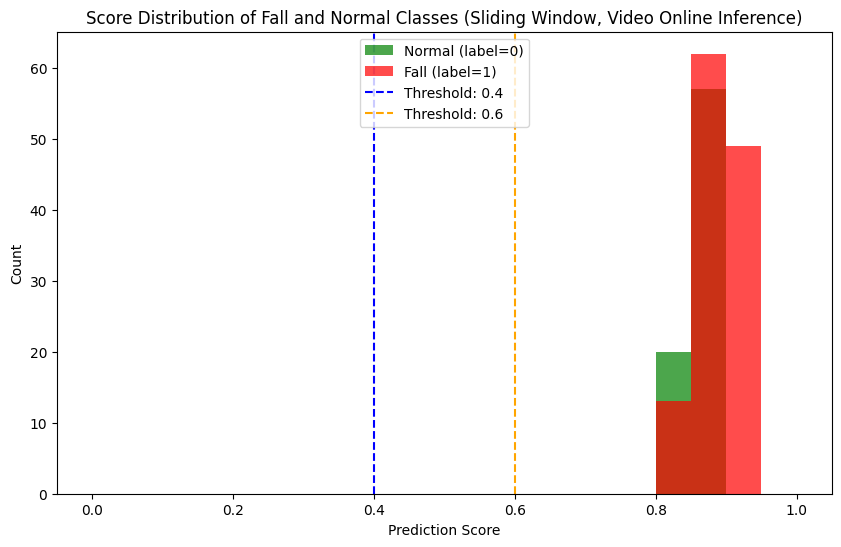

In [75]:
# 畫出所有資料夾骨架 JSON 的分數分佈直方圖
visualize_score_distribution(
    model, scaler, TEST_NORMAL_FOLDER, TEST_FALL_FOLDER, time_steps=TIME_STEPS, stride=10
)

In [59]:
# 影片推論
display_video_with_skeleton_and_fall_detection(TEST_VIDEO_PATH, model, scaler, TIME_STEPS, INFERENCE_FREQUENCY)

1/1 [==============================] - 0s 15ms/step


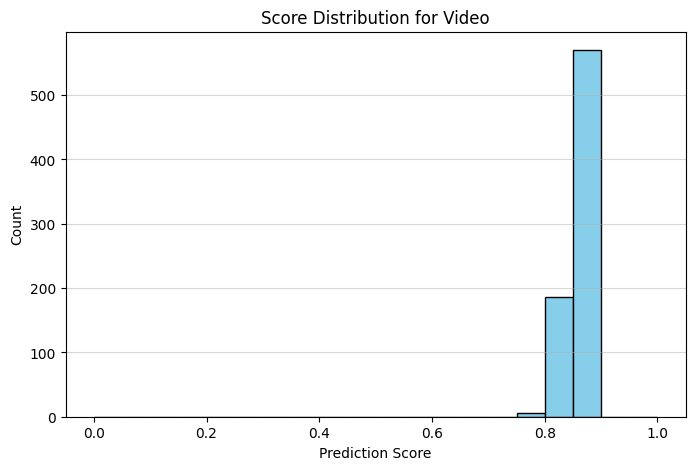

In [79]:
import matplotlib.pyplot as plt

def predict_video_score_histogram_plot(video_path, model, scaler, time_steps=60, stride=1, bin_width=0.05):
    cap = cv2.VideoCapture(video_path)
    skeleton_data = []
    scores = []
    while True:
        success, frame = cap.read()
        if not success or frame is None:
            break
        skeleton_points = extract_skeleton_points(frame)
        if skeleton_points:
            skeleton_data.append(skeleton_points)
        else:
            skeleton_data.append([(0, 0, 0)] * 33)
    cap.release()
    for start in range(0, max(1, len(skeleton_data) - time_steps + 1), stride):
        window = skeleton_data[start : start + time_steps]
        if len(window) < time_steps:
            window = [[(0, 0, 0)] * 33] * (time_steps - len(window)) + window
        accel_features = calculate_acceleration(window)
        if len(accel_features) < time_steps:
            accel_features = [[0] * 33] * (time_steps - len(accel_features)) + accel_features
        combined_data = [np.hstack((np.ravel(frame), accel)) for frame, accel in zip(window, accel_features)]
        arr = np.array(combined_data).reshape(1, -1)
        arr_norm = scaler.transform(arr).reshape(1, time_steps, -1)
        score = model.predict(arr_norm, verbose=0)[0][0]
        scores.append(score)
    bins = np.arange(0, 1 + bin_width, bin_width)
    plt.figure(figsize=(8, 5))
    plt.hist(scores, bins=bins, color='skyblue', edgecolor='black')
    plt.xlabel('Prediction Score')
    plt.ylabel('Count')
    plt.title('Score Distribution for Video')
    plt.grid(axis='y', alpha=0.5)
    plt.show()

# 範例用法
predict_video_score_histogram_plot(TEST_VIDEO_PATH, model, scaler, time_steps=TIME_STEPS, stride=1, bin_width=0.05)